# Propensity Score Diagnostics

**Chapter 11, Section 4**

This notebook covers practical diagnostics for propensity score methods.

## Table of Contents
1. [Intuition](#intuition) - Why diagnostics matter
2. [Formal Treatment](#formal) - Overlap and balance metrics
3. [Numeric Demonstration](#numeric) - Mindset data diagnostics
4. [Implementation](#implementation) - Complete diagnostic workflow
5. [Interview Appendix](#interview) - Practice questions

---

In [1]:
# Standard imports
import sys
sys.path.insert(0, '../..')

from facure_augment.common import *
from sklearn.linear_model import LogisticRegression

# Set notebook style
set_notebook_style()

print("Imports complete")

Imports complete


---

## Intuition

### Why Diagnostics Matter

Propensity score methods can fail silently in three ways:

1. **Positivity violations**: Some covariate values only appear in one treatment group
2. **Poor balance**: Weighting/matching doesn't actually balance covariates
3. **Extreme weights**: A few observations dominate the estimate

### The Three Key Diagnostics

| Diagnostic | What It Checks | Solution If Violated |
|------------|----------------|----------------------|
| PS overlap | Can everyone receive both treatments? | Trim/restrict sample |
| Covariate balance | Are covariates balanced after adjustment? | Respecify PS model |
| Weight extremity | Do a few units dominate? | Stabilize/trim weights |

---

In [2]:
# Load mindset data and estimate propensity scores
mindset = load_facure_data("learning_mindset.csv")

covariates = [
    'success_expect', 'ethnicity', 'gender', 'frst_in_family',
    'school_mindset', 'school_achievement', 'school_ethnic_minority',
    'school_poverty', 'school_size'
]

X = mindset[covariates].values
T = mindset['intervention'].values
Y = mindset['achievement_score'].values

# Estimate propensity scores
ps_model = LogisticRegression(C=1e6, max_iter=1000, solver='lbfgs')
ps_model.fit(X, T)
ps = ps_model.predict_proba(X)[:, 1]

mindset['ps'] = ps

print(f"Data: {len(mindset)} students")
print(f"Treated: {T.sum()} ({T.mean():.1%})")
print(f"Control: {(1-T).sum()} ({(1-T).mean():.1%})")

Data: 10391 students
Treated: 3384 (32.6%)
Control: 7007 (67.4%)


---

## Formal Treatment

### 1. Positivity/Overlap Assumption

**Requirement**: For all $x$ in the support,

$$0 < P(T=1|X=x) < 1$$

**In practice**: Check that PS distributions overlap.

### 2. Covariate Balance Metrics

**Standardized Mean Difference (SMD)**:

$$SMD = \frac{\bar{X}_1 - \bar{X}_0}{\sqrt{(S_1^2 + S_0^2)/2}}$$

**Rule of thumb**:
- $|SMD| < 0.1$: Good balance
- $|SMD| < 0.25$: Acceptable
- $|SMD| \geq 0.25$: Poor balance, respecify model

### 3. Weight Diagnostics

For IPTW, weights are: $w_i = T_i/e(X_i) + (1-T_i)/(1-e(X_i))$

**Effective Sample Size**:

$$ESS = \frac{(\sum w_i)^2}{\sum w_i^2}$$

Low ESS indicates a few units dominate.

---

In [3]:
def compute_smd(X, T, weights=None):
    """
    Compute Standardized Mean Difference for each covariate.
    
    Parameters:
    -----------
    X : covariate matrix
    T : treatment indicator
    weights : optional weights for weighted means
    """
    if weights is None:
        weights = np.ones(len(T))
    
    # Normalize weights within groups
    w1 = weights * T / np.sum(weights * T)
    w0 = weights * (1-T) / np.sum(weights * (1-T))
    
    smds = []
    for j in range(X.shape[1]):
        x = X[:, j]
        
        # Weighted means
        mean1 = np.sum(w1 * x)
        mean0 = np.sum(w0 * x)
        
        # Unweighted variances (for denominator)
        var1 = np.var(x[T==1])
        var0 = np.var(x[T==0])
        
        # Pooled SD
        pooled_sd = np.sqrt((var1 + var0) / 2)
        
        if pooled_sd > 0:
            smd = (mean1 - mean0) / pooled_sd
        else:
            smd = 0.0
        
        smds.append(smd)
    
    return np.array(smds)

---

## Numeric Demonstration

### Diagnostic 1: PS Distribution Overlap

/tmp/ipykernel_1115348/642705442.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([ps[T==0], ps[T==1]], labels=['Control', 'Treated'], patch_artist=True)


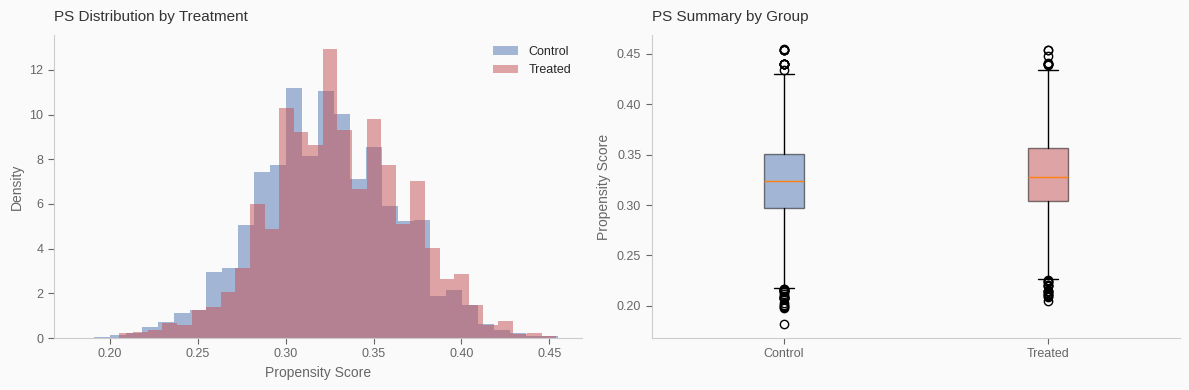

OVERLAP STATISTICS:
Control PS range: [0.1818, 0.4551]
Treated PS range: [0.2049, 0.4540]
Common support: [0.2049, 0.4540]


In [4]:
# Visualize PS overlap
fig, axes = create_tufte_figure(ncols=2, figsize=(12, 4))

# Left: Histograms
ax = axes[0]
ax.hist(ps[T==0], bins=30, alpha=0.5, color=COLORS['blue'], label='Control', density=True)
ax.hist(ps[T==1], bins=30, alpha=0.5, color=COLORS['red'], label='Treated', density=True)
set_tufte_title(ax, "PS Distribution by Treatment")
set_tufte_labels(ax, "Propensity Score", "Density")
ax.legend(frameon=False)

# Right: Box plots
ax = axes[1]
bp = ax.boxplot([ps[T==0], ps[T==1]], labels=['Control', 'Treated'], patch_artist=True)
bp['boxes'][0].set_facecolor(COLORS['blue'])
bp['boxes'][1].set_facecolor(COLORS['red'])
for box in bp['boxes']:
    box.set_alpha(0.5)
set_tufte_title(ax, "PS Summary by Group")
set_tufte_labels(ax, "", "Propensity Score")

plt.tight_layout()
plt.show()

# Overlap statistics
print("OVERLAP STATISTICS:")
print(f"Control PS range: [{ps[T==0].min():.4f}, {ps[T==0].max():.4f}]")
print(f"Treated PS range: [{ps[T==1].min():.4f}, {ps[T==1].max():.4f}]")
print(f"Common support: [{max(ps[T==0].min(), ps[T==1].min()):.4f}, {min(ps[T==0].max(), ps[T==1].max()):.4f}]")

### Diagnostic 2: Covariate Balance

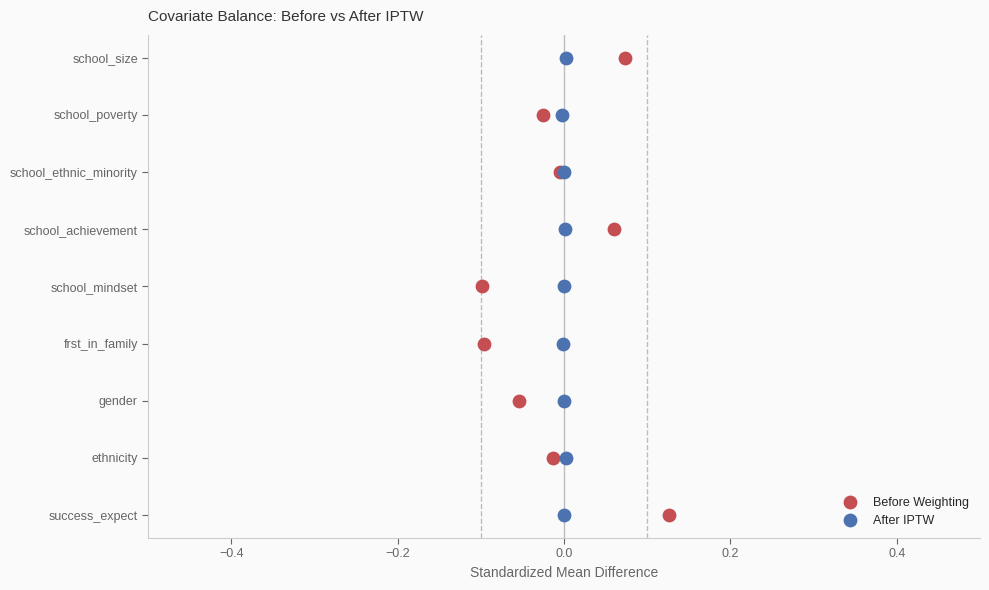


BALANCE TABLE:
Covariate                     Before      After   Improved
-------------------------------------------------------
success_expect                0.1265    -0.0007        Yes
ethnicity                    -0.0139     0.0019        Yes
gender                       -0.0544    -0.0000        Yes
frst_in_family               -0.0960    -0.0017        Yes
school_mindset               -0.0984    -0.0006        Yes
school_achievement            0.0597     0.0008        Yes
school_ethnic_minority       -0.0048    -0.0004        Yes
school_poverty               -0.0249    -0.0021        Yes
school_size                   0.0729     0.0022        Yes


In [5]:
# Compute balance before and after IPTW
weights_iptw = T / ps + (1 - T) / (1 - ps)

smd_before = compute_smd(X, T, weights=None)
smd_after = compute_smd(X, T, weights=weights_iptw)

# Create balance plot
fig, ax = create_tufte_figure(figsize=(10, 6))

y_pos = np.arange(len(covariates))

ax.scatter(smd_before, y_pos, color=COLORS['red'], s=80, label='Before Weighting', zorder=3)
ax.scatter(smd_after, y_pos, color=COLORS['blue'], s=80, label='After IPTW', zorder=3)

# Reference lines
ax.axvline(0, color='gray', linewidth=1, alpha=0.5)
ax.axvline(0.1, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax.axvline(-0.1, color='gray', linestyle='--', linewidth=1, alpha=0.5)

ax.set_yticks(y_pos)
ax.set_yticklabels(covariates)
ax.set_xlim(-0.5, 0.5)

set_tufte_title(ax, "Covariate Balance: Before vs After IPTW")
set_tufte_labels(ax, "Standardized Mean Difference", "")
ax.legend(frameon=False, loc='lower right')

plt.tight_layout()
plt.show()

# Print balance table
print("\nBALANCE TABLE:")
print(f"{'Covariate':<25} {'Before':>10} {'After':>10} {'Improved':>10}")
print("-" * 55)
for i, cov in enumerate(covariates):
    improved = abs(smd_after[i]) < abs(smd_before[i])
    print(f"{cov:<25} {smd_before[i]:>10.4f} {smd_after[i]:>10.4f} {'Yes' if improved else 'No':>10}")

### Diagnostic 3: Weight Distribution

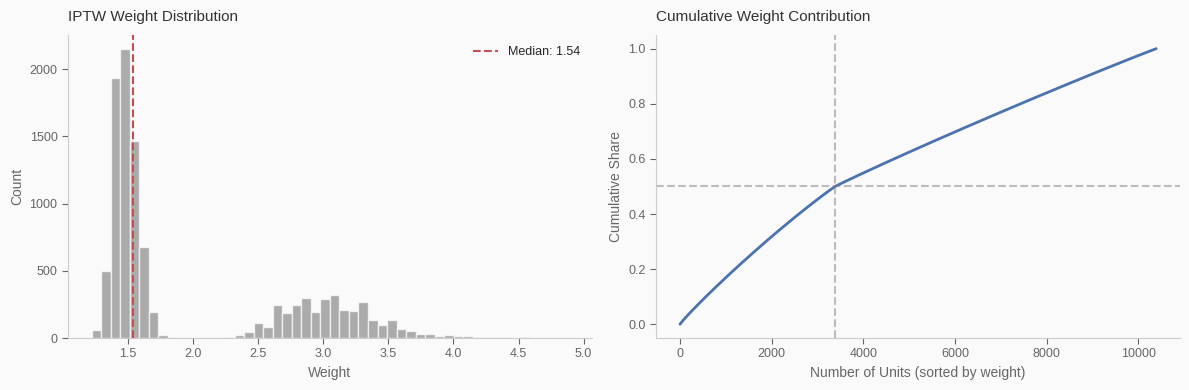


WEIGHT STATISTICS:
Weight range: [1.22, 4.88]
Weight mean: 2.00
Weight std: 0.78
Max/Median ratio: 3.2x

Effective Sample Size:
  Treated: 3334 / 3384 (98.5%)
  Control: 6983 / 7007 (99.7%)


In [6]:
def effective_sample_size(weights, treatment):
    """Compute effective sample size for each group."""
    ess_treated = np.sum(weights[treatment==1])**2 / np.sum(weights[treatment==1]**2)
    ess_control = np.sum(weights[treatment==0])**2 / np.sum(weights[treatment==0]**2)
    return ess_treated, ess_control

# Weight diagnostics
fig, axes = create_tufte_figure(ncols=2, figsize=(12, 4))

# Left: Weight distribution
ax = axes[0]
ax.hist(weights_iptw, bins=50, color=COLORS['gray'], edgecolor='white', alpha=0.7)
ax.axvline(np.median(weights_iptw), color=COLORS['red'], linestyle='--', label=f'Median: {np.median(weights_iptw):.2f}')
set_tufte_title(ax, "IPTW Weight Distribution")
set_tufte_labels(ax, "Weight", "Count")
ax.legend(frameon=False)

# Right: Extreme weights
ax = axes[1]
sorted_weights = np.sort(weights_iptw)[::-1]
cumsum = np.cumsum(sorted_weights) / np.sum(sorted_weights)
ax.plot(np.arange(1, len(cumsum)+1), cumsum, color=COLORS['blue'], linewidth=2)
ax.axhline(0.5, color='gray', linestyle='--', alpha=0.5)
ax.axvline(np.searchsorted(cumsum, 0.5), color='gray', linestyle='--', alpha=0.5)
set_tufte_title(ax, "Cumulative Weight Contribution")
set_tufte_labels(ax, "Number of Units (sorted by weight)", "Cumulative Share")

plt.tight_layout()
plt.show()

# Compute ESS
ess_t, ess_c = effective_sample_size(weights_iptw, T)

print("\nWEIGHT STATISTICS:")
print(f"Weight range: [{weights_iptw.min():.2f}, {weights_iptw.max():.2f}]")
print(f"Weight mean: {weights_iptw.mean():.2f}")
print(f"Weight std: {weights_iptw.std():.2f}")
print(f"Max/Median ratio: {weights_iptw.max()/np.median(weights_iptw):.1f}x")
print(f"\nEffective Sample Size:")
print(f"  Treated: {ess_t:.0f} / {T.sum()} ({ess_t/T.sum():.1%})")
print(f"  Control: {ess_c:.0f} / {(1-T).sum()} ({ess_c/(1-T).sum():.1%})")

---

## Implementation

### Weight Trimming (Use with Caution)

In [7]:
def trim_weights(weights, percentile=99):
    """
    Trim extreme weights to a percentile threshold.
    
    WARNING: Trimming introduces bias. Use only when
    extreme weights dominate the estimate.
    """
    threshold = np.percentile(weights, percentile)
    trimmed = np.minimum(weights, threshold)
    return trimmed

def iptw_ate_comparison(Y, T, ps, trim_pct=None):
    """Compare IPTW with and without trimming."""
    # Standard weights
    weights = T / ps + (1 - T) / (1 - ps)
    
    if trim_pct is not None:
        weights = trim_weights(weights, trim_pct)
    
    # Hajek estimator
    mu1 = np.sum(T * Y * weights) / np.sum(T * weights)
    mu0 = np.sum((1 - T) * Y * weights) / np.sum((1 - T) * weights)
    
    return mu1 - mu0

# Compare estimates
print("IPTW SENSITIVITY TO TRIMMING:")
print("=" * 50)
for pct in [None, 99, 95, 90]:
    ate = iptw_ate_comparison(Y, T, ps, trim_pct=pct)
    label = f"Trim {pct}%" if pct else "No trimming"
    print(f"{label:<15}: ATE = {ate:.4f}")

IPTW SENSITIVITY TO TRIMMING:
No trimming    : ATE = 0.3946
Trim 99%       : ATE = 0.3970
Trim 95%       : ATE = 0.4059
Trim 90%       : ATE = 0.4138


In [8]:
# Complete diagnostic workflow
def ps_diagnostic_summary(X, T, Y, covariates, ps):
    """Generate complete PS diagnostic summary."""
    weights = T / ps + (1 - T) / (1 - ps)
    
    # 1. Overlap
    overlap_min = max(ps[T==0].min(), ps[T==1].min())
    overlap_max = min(ps[T==0].max(), ps[T==1].max())
    overlap_good = overlap_min < 0.1 and overlap_max > 0.9
    
    # 2. Balance
    smd_before = compute_smd(X, T, weights=None)
    smd_after = compute_smd(X, T, weights=weights)
    max_smd_before = np.max(np.abs(smd_before))
    max_smd_after = np.max(np.abs(smd_after))
    balance_improved = max_smd_after < max_smd_before
    balance_good = max_smd_after < 0.1
    
    # 3. Weights
    ess_t, ess_c = effective_sample_size(weights, T)
    ess_ratio_t = ess_t / T.sum()
    ess_ratio_c = ess_c / (1-T).sum()
    weights_good = min(ess_ratio_t, ess_ratio_c) > 0.5
    
    print("PS DIAGNOSTIC SUMMARY")
    print("=" * 60)
    print(f"\n1. OVERLAP:")
    print(f"   Common support: [{overlap_min:.4f}, {overlap_max:.4f}]")
    print(f"   Status: {'GOOD' if overlap_good else 'CHECK'}")
    print(f"\n2. BALANCE:")
    print(f"   Max SMD before: {max_smd_before:.4f}")
    print(f"   Max SMD after:  {max_smd_after:.4f}")
    print(f"   Improved: {'Yes' if balance_improved else 'No'}")
    print(f"   Status: {'GOOD' if balance_good else 'CHECK'}")
    print(f"\n3. WEIGHTS:")
    print(f"   ESS treated: {ess_t:.0f}/{T.sum()} ({ess_ratio_t:.1%})")
    print(f"   ESS control: {ess_c:.0f}/{int((1-T).sum())} ({ess_ratio_c:.1%})")
    print(f"   Status: {'GOOD' if weights_good else 'CHECK'}")
    print(f"\n" + "=" * 60)
    overall = 'GOOD' if (overlap_good and balance_good and weights_good) else 'REVIEW NEEDED'
    print(f"OVERALL: {overall}")

ps_diagnostic_summary(X, T, Y, covariates, ps)

PS DIAGNOSTIC SUMMARY

1. OVERLAP:
   Common support: [0.2049, 0.4540]
   Status: CHECK

2. BALANCE:
   Max SMD before: 0.1265
   Max SMD after:  0.0022
   Improved: Yes
   Status: GOOD

3. WEIGHTS:
   ESS treated: 3334/3384 (98.5%)
   ESS control: 6983/7007 (99.7%)
   Status: GOOD

OVERALL: REVIEW NEEDED


---

## Interview Appendix

### Practice Questions

**Q1: How do you check if propensity score estimation worked?**

<details>
<summary>Solution</summary>

**Three key diagnostics**:

1. **Overlap/Positivity**:
   - Plot PS distributions for treated and control
   - Check for common support (both groups have similar PS ranges)
   - Red flag: No overlap in certain regions

2. **Covariate Balance**:
   - Compute SMD before and after weighting/matching
   - Target: |SMD| < 0.1 for all covariates
   - If balance doesn't improve, respecify PS model

3. **Weight Extremity**:
   - Check weight distribution and ESS
   - Red flag: ESS < 50% of nominal sample
   - Consider stabilized weights or trimming (with caution)

**Key insight**: The PS model doesn't need to be "correct" - it needs to achieve balance.

</details>

**Q2: What is the positivity assumption and why does it matter?**

<details>
<summary>Solution</summary>

**Definition**: $0 < P(T=1|X=x) < 1$ for all $x$ in the support.

**Interpretation**: Every unit has some chance of receiving either treatment.

**Why it matters**:
- IPTW uses weights $1/e(X)$ and $1/(1-e(X))$
- If $e(X) \approx 0$ or $e(X) \approx 1$, weights explode
- This leads to high variance and unstable estimates

**Practical violations**:
- Deterministic treatment rules (age > 65 always gets Medicare)
- Rare covariate combinations only in one group

**Solutions**:
- Restrict analysis to common support
- Trim extreme propensity scores (e.g., keep 0.05 < PS < 0.95)
- Use doubly robust methods (more stable with near-violations)

</details>

**Q3: What is the effective sample size and when should you worry?**

<details>
<summary>Solution</summary>

**Definition**: $ESS = (\sum w_i)^2 / \sum w_i^2$

**Interpretation**: The number of equally-weighted observations that would give the same variance.

**Example**:
- 1000 observations, but 10 have huge weights
- ESS might be only 50-100
- Your estimate is effectively based on 50-100 units

**When to worry**:
- ESS < 50% of nominal sample → Significant information loss
- ESS < 30% → Results dominated by few observations
- Very low ESS → May need different method entirely

**Solutions**:
1. Stabilized weights: $w_i = P(T_i) / e(X_i)$ instead of $1/e(X_i)$
2. Weight trimming (introduces bias)
3. Consider matching instead of weighting

</details>

---

## References

[^1]: Facure, M. (2022). *Causal Inference for the Brave and True*, Chapter 11.

[^2]: Austin, P. C. (2009). Balance diagnostics for comparing the distribution of baseline covariates between treatment groups in propensity-score matched samples. *Statistics in Medicine*, 28(25), 3083-3107.

[^3]: Crump, R. K., et al. (2009). Dealing with limited overlap in estimation of average treatment effects. *Biometrika*, 96(1), 187-199.

[^4]: Cross-reference: `src/causal_inference/psm/diagnostics.py` for production balance metrics.